In [6]:
import numpy as np
from pickle import load
from votekit.utils import mentions
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
import matplotlib.pyplot as plt

# A nice function for showing matrix heatmaps
def show_matrix(M, title=None, labels = None, cmap='viridis'):
    fig, ax = plt.subplots()
    if title:
        plt.title(title)
    img = ax.imshow(M, cmap=cmap)
    fig.colorbar(img)
    if labels:
        ax.set_xticks(range(M.shape[0]))
        ax.set_xticklabels(labels)
        ax.set_yticks(range(M.shape[1]))
        ax.set_yticklabels(labels)
        ax.tick_params(axis='x', labelrotation=90)
        ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
    ax.set_aspect('auto')
    plt.show()


Let's load a voter profile for analysis

In [7]:
with open('../github/data/Portland_D1.pkl', 'rb') as file:
    loaded = load(file)

In [8]:
loaded.keys()

dict_keys(['profile', 'boost', 'distance', 'comentions', 'candidates'])

In [9]:
boost = loaded['boost']
profile = loaded['profile']
candidates = loaded['candidates']
candidate_to_index = {candidate : i for i, candidate in enumerate(candidates)}
num_mentions = mentions(profile)

In [10]:
num_mentions = {key : value for key,value in num_mentions.items() if key in candidates}
num_mentions

{'Candace Avalos': 22332.0,
 'Cayle Tern': 9106.0,
 'Jamie Dunphy': 18561.0,
 'Loretta Smith': 18115.0,
 'Steph Routh': 20511.0,
 'Doug Clove': 7648.0,
 'Michael (Mike) Sands': 5233.0,
 'David Linn': 9358.0,
 'Timur Ender': 16918.0,
 'Deian Salazar': 5284.0,
 'Peggy Sue Owens': 3908.0,
 'Joe Allen': 4985.0,
 'Joe Furi': 4095.0,
 'Terrence Hayes': 16089.0,
 'Noah Ernst': 11696.0,
 'Thomas Shervey': 3543.0}

In [11]:
total_mentions = sum(num_mentions.values())
share_mentions = {key : value/total_mentions for key,value in num_mentions.items()}

del num_mentions

share_mentions

{'Candace Avalos': 0.1258977799325749,
 'Cayle Tern': 0.051335535736433235,
 'Jamie Dunphy': 0.10463857663122526,
 'Loretta Smith': 0.10212422906495586,
 'Steph Routh': 0.11563180029540765,
 'Doug Clove': 0.04311598696598302,
 'Michael (Mike) Sands': 0.029501302274187912,
 'David Linn': 0.05275619848688142,
 'Timur Ender': 0.09537608100032698,
 'Deian Salazar': 0.029788817354635757,
 'Peggy Sue Owens': 0.022031547733140904,
 'Joe Allen': 0.02810318972612779,
 'Joe Furi': 0.02308576969478301,
 'Terrence Hayes': 0.0907025515554002,
 'Noah Ernst': 0.06593679178270626,
 'Thomas Shervey': 0.019973841765229844}

In [13]:
sum(share_mentions.values())

1.0

Let's cook up some ways to evaluate partitions of candidates.

First, the cut score of a partition. That is, we construct the matrix $M$ such that $M_{ij}$ is the number of times candidate $i$ appeared next to candidate $j$ on a ballot. The cut score of a partition $P$ of the candidates is
$$
\sum_{S,S'\in P, S\neq S'} \sum_{x\in S, y\in S'} M_{xy}.
$$


In [ ]:
adjacencies = np.zeros((len(candidates), len(candidates)))

for ballot in tqdm(profile.ballots):
    ranking = []
    for set in ballot.ranking:
        if len(set) == 1:
            name, = set
            if name in ranking:
                continue #Repeated name in this one. Throw it out.
            if name in candidates:
                ranking.append(name) #Ignore names that aren't in the candidate list
    
    if len(ranking) <= 1:
        continue
    
    for i in range(len(ranking) - 1):
        adjacencies[candidate_to_index[ranking[i]],
                    candidate_to_index[ranking[i-1]]
                    ] += ballot.weight
        
adjacencies = adjacencies + adjacencies.T

  0%|          | 0/19933 [00:00<?, ?it/s]

100%|██████████| 19933/19933 [00:00<00:00, 169857.18it/s]


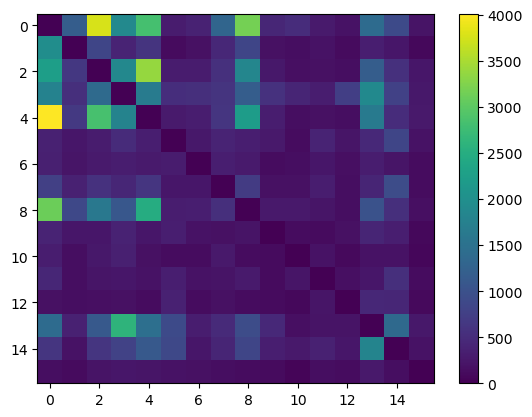

In [15]:
show_matrix(adjacencies)

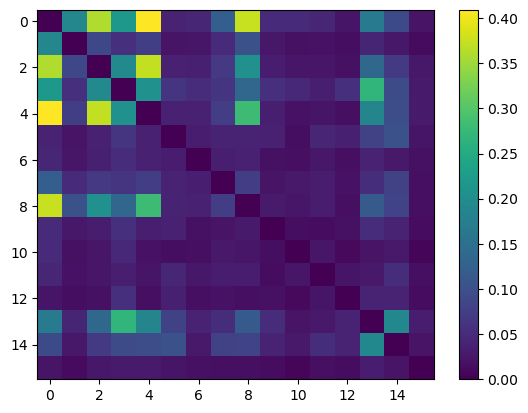

np.float64(0.062499999999999986)

In [224]:
adjacencies /= (adjacencies.mean() * len(candidates))

show_matrix(adjacencies)
adjacencies.mean()

In [23]:
# Ready to define the cut score
def cut_score(partitions):
    sum = 0
    for part1 in partitions:
        for part2 in partitions:
            if part1 == part2:
                continue
            for c1 in part1:
                for c2 in part2:
                    sum += adjacencies[
                        candidate_to_index[c1],
                        candidate_to_index[c2]
                        ]
    return sum

Another metric by which to judge partitions: relative sizes. A partition with very different sizes would be a poor partition. Given a partition $P$ of candidates, define the Achlioptas score to be
$$
\prod_{S\in P} \mathrm{mentions}(S)
$$
where $\mathrm{mentions}(S)$ is the sum of all the mentions of the candidates in the set $S$.

This score is maximized when all the partitions have the same number of mentions. If we'd rather be minimizing, we can instead use the inverse
$$
\prod_{S\in P} \frac{1}{\mathrm{mentions}(S)}.
$$

In [26]:
def relative_size_score(partitions):
    sizes = []
    for part in partitions:
        sizes.append(
            sum([share_mentions[candidate] for candidate in part])
        )
    score = 1
    for size in sizes:
        score *= size
    return 1/score

We could also look specifically at the first and second place votes in each ballot.

[FILL IN HERE]

Given metrics we want to minimize, we can use a Markov chain to find partitions that minimize them. Let's spin up a simple Markov chain.

In [27]:
# We'll need a random starting place for our Markov chain.
def random_partition(lst, k):
    shuffled = lst[:]
    random.shuffle(shuffled)
    partition = [[] for _ in range(k)]
    for idx, item in enumerate(shuffled):
        partition[idx % k].append(item)
    return partition

k = 2 # Number of slates we want to find
partition = random_partition(candidates, k)
partition

[['Timur Ender',
  'Terrence Hayes',
  'Cayle Tern',
  'Noah Ernst',
  'Loretta Smith',
  'Peggy Sue Owens',
  'David Linn',
  'Thomas Shervey'],
 ['Joe Furi',
  'Jamie Dunphy',
  'Joe Allen',
  'Doug Clove',
  'Candace Avalos',
  'Michael (Mike) Sands',
  'Deian Salazar',
  'Steph Routh']]

In [28]:
# The heart of the Markov chain. Given a partition of the candidates, propose a new partition.
def proposal(partition, candidates):
    partition = [part.copy() for part in partition]
    random_candidate = candidates[random.randint(0,len(candidates)-1)]
    random_partition = random.randint(0,len(partition)-1)
    #Remove the random candidate from their partition
    for part in partition:
        if random_candidate in part:
            if len(part) == 1: #If this is the last candidate, don't remove them
                return partition
            part.remove(random_candidate)
    partition[random_partition].append(random_candidate)
    return partition

# The objective we want to minimize
def total_score(partition):
    alpha, beta = 10, 5 #Change these to balance the objectives!
    return alpha * cut_score(partition) + beta * relative_size_score(partition)


In [ ]:
# Here's the random partition we're starting with.
partition

[['Timur Ender',
  'Terrence Hayes',
  'Cayle Tern',
  'Noah Ernst',
  'Loretta Smith',
  'Peggy Sue Owens',
  'David Linn',
  'Thomas Shervey'],
 ['Joe Furi',
  'Jamie Dunphy',
  'Joe Allen',
  'Doug Clove',
  'Candace Avalos',
  'Michael (Mike) Sands',
  'Deian Salazar',
  'Steph Routh']]

In [31]:
# Run the Markov chain
num_steps = 20000
cur_score = total_score(partition)
best_score = cur_score
best_partition = [part.copy() for part in partition]

for _ in range(num_steps):
    new_partition = proposal(partition, candidates)
    new_score = total_score(new_partition)
    cutoff = np.exp(cur_score - new_score)
    if np.random.random() < cutoff:
        partition = new_partition
        cur_score = new_score
        if cur_score < best_score:
            best_score = cur_score
            best_partition = [part.copy() for part in partition]
            print("New best!")

In [41]:
print("Best total score:", best_score)
print("Cut score:", cut_score(best_partition))
print("Achlioptas score:", relative_size_score(best_partition))

print("Best partition:")
display(best_partition)


Best total score: 61201.7017951678
Cut score: 6098.0
Achlioptas score: 44.34035903356048
Best partition:


[['Joe Furi'],
 ['Candace Avalos',
  'Steph Routh',
  'Jamie Dunphy',
  'Loretta Smith',
  'Timur Ender',
  'Terrence Hayes',
  'Noah Ernst',
  'David Linn',
  'Cayle Tern',
  'Doug Clove',
  'Deian Salazar',
  'Michael (Mike) Sands',
  'Joe Allen',
  'Peggy Sue Owens',
  'Thomas Shervey']]

In [42]:
# Sort each slate of candidates by mentions
for part in best_partition:
    part.sort(key=(lambda x: share_mentions[x]), reverse=True)
best_partition

[['Joe Furi'],
 ['Candace Avalos',
  'Steph Routh',
  'Jamie Dunphy',
  'Loretta Smith',
  'Timur Ender',
  'Terrence Hayes',
  'Noah Ernst',
  'David Linn',
  'Cayle Tern',
  'Doug Clove',
  'Deian Salazar',
  'Michael (Mike) Sands',
  'Joe Allen',
  'Peggy Sue Owens',
  'Thomas Shervey']]

In [43]:
#Combine into one order!
candidate_order = []
for part in best_partition:
    candidate_order += part

candidate_order

['Joe Furi',
 'Candace Avalos',
 'Steph Routh',
 'Jamie Dunphy',
 'Loretta Smith',
 'Timur Ender',
 'Terrence Hayes',
 'Noah Ernst',
 'David Linn',
 'Cayle Tern',
 'Doug Clove',
 'Deian Salazar',
 'Michael (Mike) Sands',
 'Joe Allen',
 'Peggy Sue Owens',
 'Thomas Shervey']

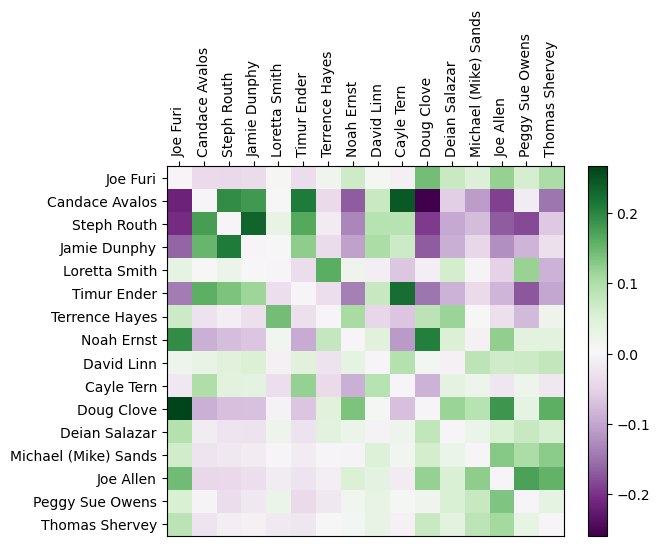

In [44]:
# Let's permute the boost matrix and see how it looks
permutation_list = []
for candidate in candidates:
    permutation_list.append(
        candidate_order.index(candidate)
    )

permutation_matrix = np.zeros((len(candidates),len(candidates)))
for i, p in enumerate(permutation_list):
    permutation_matrix[i,p] = 1

show_matrix(permutation_matrix.T @ boost @ permutation_matrix, labels = candidate_order, cmap='PRGn')